## Imports

In [1]:
import logging  # Allows you to set levels of verbosity for printing information warnings and errors
import elfi  # SMC / Liklihood free inference
import numpy as np  # Matrices and linear algebra
import scipy.stats  # Statistics
import seaborn as sns  # Plotting
import matplotlib.pyplot as plt  # Plotting
from sklearn.preprocessing import StandardScaler  # Carries out standard scaling (x-mu)/sd
import pandas as pd  # DataFrames
import pickle  # Serializes objects

import torch
import torch.distributions
from torch import Tensor
from sbi.inference import SNLE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.user_input_checks import process_prior
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils
from sbi import analysis as analysis

from sim.utils import ScaledDist
from sim.model import simple_sim
from sim.sum_stats import simple_sum

import snle.priors_torch as priors

# Set the logging level to info
logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)


## Read in data

In [2]:
stats_df = pd.read_csv("../data/stats.csv", index_col="index").sort_values("index").drop(columns=["random_seed"]).dropna()
stats_df

,divergence_domestic_captive,divergence_domestic_wild,divergence_wild_captive,diversity_all_pops,diversity_captive,diversity_domestic,diversity_wild,expected_heterozygosity_all_pops,expected_heterozygosity_captive,expected_heterozygosity_domestic,...,sfs_mean_wild_24_30,sfs_mean_wild_6_12,tajimas_d_all_pops,tajimas_d_captive,tajimas_d_domestic,tajimas_d_wild,wattersons_theta_all_pops,wattersons_theta_captive,wattersons_theta_domestic,wattersons_theta_wild
index,,,,,,,,,,,,,,,,,,,,,
0,0.003738,0.001996,0.003207,0.002727,0.002638,0.000391,0.002603,0.214448,0.199299,0.027959,...,406.000000,1738.000000,0.344489,0.456622,-1.310533,0.251633,0.002479,0.002379,0.000528,0.002433
1,0.002809,0.000845,0.002836,0.001790,0.002962,0.000436,0.001194,0.148601,0.236271,0.032930,...,38.500000,2069.833333,-0.820895,0.810598,-1.041854,-1.578118,0.002348,0.002483,0.000550,0.002129
2,0.002317,0.001398,0.002558,0.002117,0.002858,0.000440,0.002003,0.149706,0.194118,0.028338,...,16.666667,4022.000000,-0.801507,0.343705,-1.446273,-0.877543,0.002758,0.002642,0.000618,0.002650
3,0.002419,0.001464,0.002548,0.002146,0.002732,0.000380,0.002056,0.179589,0.219637,0.028919,...,10.666667,2297.166667,-0.272599,0.676929,-1.102112,-0.324568,0.002330,0.002353,0.000486,0.002260
4,0.004324,0.002538,0.002785,0.002701,0.001490,0.000425,0.002703,0.231717,0.122831,0.033176,...,6456.166667,834.500000,0.650159,-0.700293,-1.289536,0.792414,0.002273,0.001789,0.000572,0.002215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.003031,0.001661,0.002685,0.002282,0.002343,0.000375,0.002177,0.197848,0.195105,0.029619,...,1.333333,975.166667,0.050643,0.586806,-1.470250,-0.000826,0.002249,0.002055,0.000531,0.002177
6996,0.004030,0.002353,0.003037,0.002789,0.002260,0.000301,0.002750,0.204545,0.159196,0.020091,...,4626.166667,2187.666667,0.169316,-0.576836,-1.283264,0.213567,0.002659,0.002620,0.000404,0.002595
6997,0.002924,0.001502,0.002299,0.001956,0.001518,0.000439,0.001854,0.183010,0.136447,0.037415,...,695.666667,857.000000,-0.212024,-0.367614,-1.458361,-0.239857,0.002084,0.001664,0.000619,0.001986


In [3]:
# Only take the priors that there are summary statistics for in the table above
priors_df = pd.read_feather("../data/params.feather")
priors_df[priors_df.index.isin(stats_df.index)]

,bottleneck_strength_domestic,bottleneck_strength_wild,bottleneck_time_domestic,bottleneck_time_wild,captive_time,div_time,mig_length_post_split,mig_length_wild,mig_rate_captive,mig_rate_post_split,mig_rate_wild,pop_size_wild_1,pop_size_wild_2,pop_size_captive,pop_size_domestic_1,pop_size_domestic_2
0,11179.681200,8581.601075,3654.899668,3291.806520,13.502363,46680.457221,6346.826923,16.202815,0.058944,0.116402,0.072175,6255.730274,7945.064619,133.534390,6451.196306,7699.512587
1,20482.341086,16404.120378,4232.065306,3728.075174,22.553406,44641.534301,4880.812376,13.077160,0.059210,0.109968,0.176588,6877.912755,5949.057501,154.701628,7971.442694,11450.314844
2,3.369323,3523.450783,3774.345412,3685.196173,7.229414,42802.803862,3277.696186,20.579393,0.071179,0.559360,0.065024,5256.207158,10799.396570,117.361874,6112.577699,9694.793723
3,8161.556827,9239.064011,3753.769579,3756.369852,14.865991,36737.027154,2062.518501,10.036191,0.184065,0.195405,0.096693,5949.903606,5668.604996,152.402764,8791.844465,10339.598508
4,4087.355058,21417.550593,4059.054514,2303.246484,27.651080,43950.048934,5090.117954,15.307157,0.067246,0.003630,0.041867,7566.267953,8116.905291,50.868131,7052.261649,8565.590984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,25762.055938,8544.387639,3497.696178,3170.649167,14.494486,38464.216978,2829.029391,19.162108,0.059138,0.093500,0.048655,6543.943674,8892.307209,85.487842,6500.240716,8315.355824
6996,8226.360603,3208.788505,2778.179859,3773.609317,17.825978,36571.497401,1255.149333,8.596369,0.047411,0.200960,0.065264,6265.198301,6798.928747,198.840613,8564.502461,10553.802891
6997,9486.959883,20075.013413,3997.252663,2785.449488,12.561043,37385.286829,9215.757794,11.471070,0.073316,0.027995,0.084003,5052.895389,10867.939909,86.849027,5297.681186,10376.162402
6998,20876.925930,17181.740323,3299.520275,2757.069783,25.716772,41551.395196,3992.082869,14.792078,0.216711,0.093156,0.070845,7154.839465,10807.980842,118.455591,5259.432686,7955.366795


**Define number of parameters, summary stats, etc. to use here:**

In [4]:
num_simulations = len(stats_df.index)
num_stats_to_use = len(stats_df.columns)
num_params_to_use = 16
num_samples = num_simulations
# The file to save the samples to and read from when plotting
samples_file = "../data/posterior_samples.csv"
print(f'Using {num_simulations} simulations, {num_params_to_use} params, {num_stats_to_use} summary stats and making {num_samples} samples')

Using 6880 simulations, 16 params, 102 summary stats and making 6880 samples


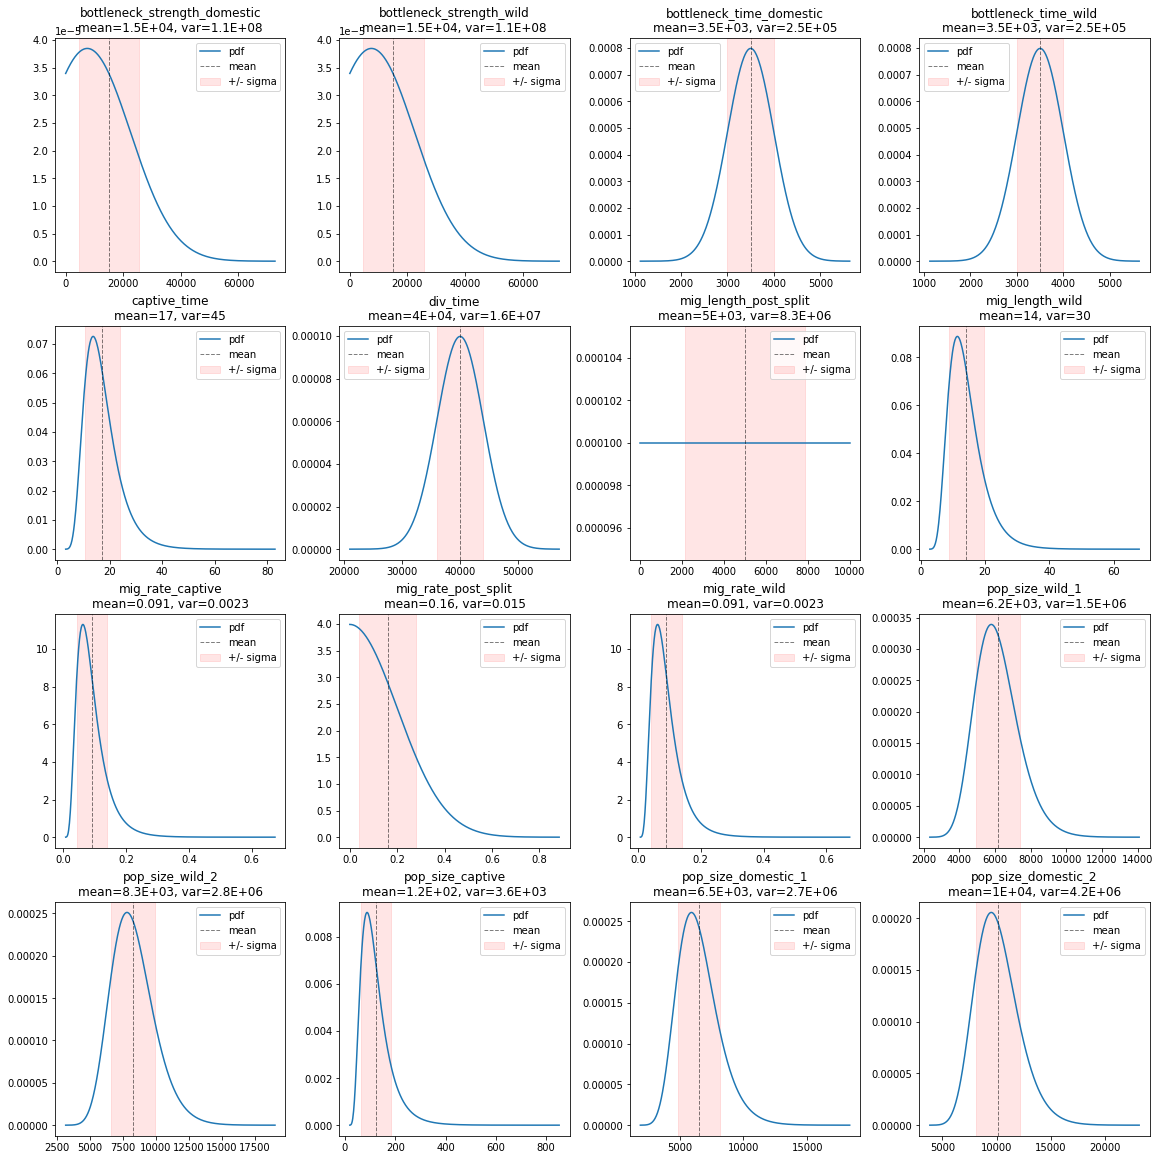

In [5]:
dists = dict(list(priors.distributions.items())[:num_params_to_use])
joint_prior = priors.join_priors(dists)
priors.plot_all_priors(dists)

## Inference
If you already have a .csv of posterior samples, you can skip this section and run the plotting on the file

TODO: Try snpe

In [ ]:
# Get the prior in the right format for sbi
prior, _, _ = process_prior(joint_prior)

In [ ]:
# Get the parameters and outputs into torch tensors
theta = Tensor([x[:num_params_to_use] for x in priors_df.values[:num_simulations]])
x = Tensor([x[:num_stats_to_use] for x in stats_df.values[:num_simulations]])
print(f'{theta.shape = }')
print(f'{x.shape = }')

In [ ]:
%%time
# Calculate the posterior
inference = SNLE(prior=prior, device='gpu').append_simulations(theta, x)
density_estimator = inference.train(show_train_summary=True)
posterior = inference.build_posterior(density_estimator)
print(posterior)

In [ ]:
%%time
# We observe x_o
x_o = x[-1]
# posterior_samples = posterior.sample((num_samples,), x=x_o, mcmc_method='nuts', mcmc_parameters={'thin': 1})
posterior_samples = posterior.sample((num_samples,), x=x_o, mcmc_method='hmc', mcmc_parameters={'thin': 1, 'num_chains': 1})
print("Done, saving to csv...")
pd.DataFrame(np.array(posterior_samples)).to_csv(samples_file)

- **8min 48s + 13min 18s** Using 6880 simulations, 5 params, 102 summary stats and making 6880 samples with hmc
- **11min 12s + 2m 52s** Using 6880 simulations, 6 params, 102 summary stats and making 6880 samples with hmc
- **Takes too long (~40s/it)** Using 6880 simulations, 10 params, 102 summary stats and making 6880 samples with hmc

Training seems to take ~ the same amount of time no matter the number of parameters

## Plotting

In [6]:
posterior_samples = pd.read_csv(samples_file, index_col=0).values

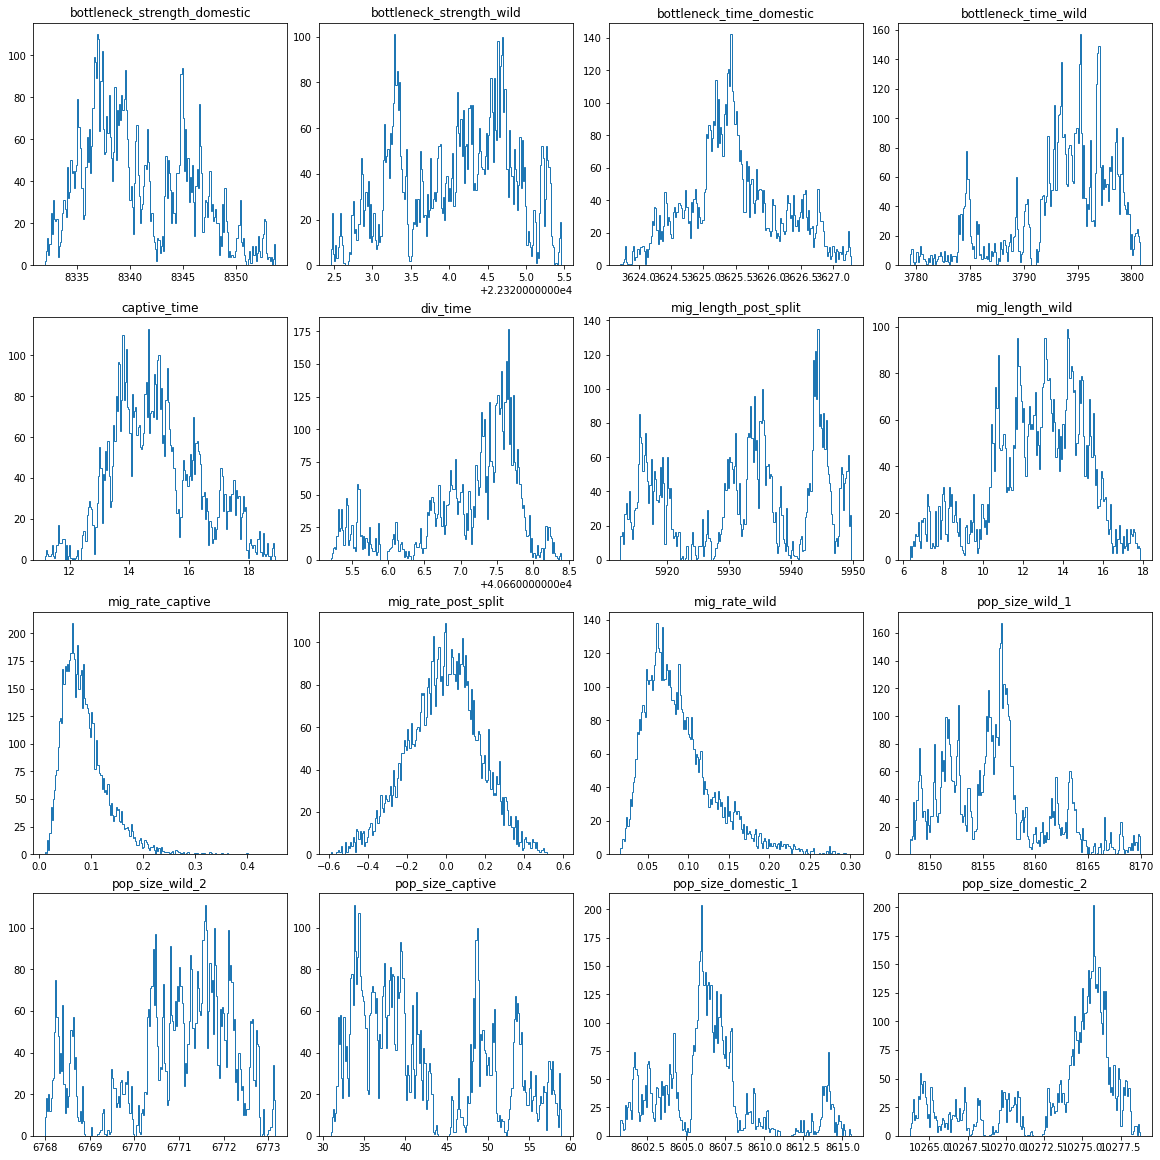

In [7]:
num_cols = 4
num_rows = int(np.ceil(posterior_samples.shape[1] / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, constrained_layout=True, figsize=(4 * num_cols, 4 * num_rows))

for ax, param, samples in zip(axes.flat, dists.keys(), np.array(posterior_samples).T):
#     low, high = priors.get_prior_limits(param)
    low, high = (samples.min(), samples.max())
    if high == low: high += 1
    ax.hist(samples, histtype='step', bins=np.arange(low, high, (high - low) / 200))
    ax.set_title(param)
plt.show()